# Common Imports

In [193]:
!pip install pandasql

In [2]:
!pip install -U sentence-transformers

     |████████████████████████████████| 81kB 3.7MB/s 
     |████████████████████████████████| 2.1MB 23.8MB/s 
     |████████████████████████████████| 1.2MB 53.6MB/s 
     |████████████████████████████████| 3.3MB 64.2MB/s 
     |████████████████████████████████| 901kB 55.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=2febb95196c5559bd37beaac84d5fc56d8ece0e8e01ad32d9b48c4a1de10727f
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [3]:
!pip install -q tensorflow-lattice

     |████████████████████████████████| 225kB 4.1MB/s 
     |████████████████████████████████| 256kB 28.9MB/s 


In [78]:
!pip install leven

     |████████████████████████████████| 163kB 6.3MB/s 
  Created wheel for leven: filename=leven-1.0.4-cp37-cp37m-linux_x86_64.whl size=55485 sha256=82d8f8bce28a39aa7ad87188e9ff1040fae4796d55ee1dd84bb2d05aa73f97ee
  Stored in directory: /root/.cache/pip/wheels/54/64/a5/439db671d666a50f3b3cebd2dcab3fbbab02785adf58e47552
Successfully built leven


In [166]:
import torch
import copy
import numpy as np
import pandas as pd
import pandasql as ps
import matplotlib.pyplot as plt
import sys
import logging
import tensorflow as tf
import tensorflow_lattice as tfl
from tensorflow import feature_column as fc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score, precision_recall_fscore_support, precision_recall_curve
from sentence_transformers import SentenceTransformer, util, InputExample, losses, evaluation
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score
from leven import levenshtein
from tqdm import tqdm_notebook

In [5]:
pd.options.display.max_colwidth = 90
logging.disable(sys.maxsize)

# Uploading Data

Upload ltable.csv, rtable.csv, train.csv before running the following cells

In [6]:
ltable = pd.read_csv("./ltable.csv")
rtable = pd.read_csv("./rtable.csv")
train_index = pd.read_csv("./train.csv")

In [7]:
print(ltable.shape)
ltable.head()

(2554, 6)


,id,title,category,brand,modelno,price
0,0,draper infrared remote transmitter,electronics - general,draper,121066,58.45
1,1,epson 1500 hours 200w uhe projector lamp elplp12,monitors,epson,elplp12,438.84
2,2,comprehensive two-piece 75 precision bnc jack for rg-59 set of 25,tv accessories,comprehensive,bj-2c7559,59.25
3,3,d-link dcs-1100 network camera,garden - general,d-link,dcs-1100,99.82
4,4,startech.com rkpw247015 24 outlet power strip,electronics - general,startech,rkpw247015,59.00


In [8]:
print(rtable.shape)
rtable.head()

(22074, 6)


,id,title,category,brand,modelno,price
0,0,koss eq50 3-band stereo equalizer,headphone accessories,koss,152132,12.65
1,1,kodak black ink cartridge 10b 1163641,inkjet printer ink,kodak,1163641,10.28
2,2,kingston 128mx64 pc2700 compaq evo d320 ktc-d320 1g,computers accessories,kingston,ktc-d320 / 1g,33.75
3,3,kinamax ms-ues2 mini high precision usb 3-button 3d optical scroll wheel mouse with re...,mice,kinamax,ms-ues2,6.99
4,4,kensington k72349us wireless mouse for netbooks,mice,kensington,k72349us,24.00


In [9]:
print(train_index.shape)
train_index.head()

(5000, 3)


,ltable_id,rtable_id,label
0,1707,19521,0
1,2471,18443,0
2,492,12502,0
3,1661,18762,0
4,636,8689,0


In [10]:
labelled_data_query = """SELECT  ltable_id, ltable.title ltable_title, 
                              ltable.category ltable_category, ltable.brand ltable_brand,
                              ltable.modelno ltable_modelno, ltable.price ltable_price,
                              rtable_id, rtable.title rtable_title, 
                              rtable.category rtable_category, rtable.brand rtable_brand,
                              rtable.modelno rtable_modelno, rtable.price rtable_price,
                              label
                      FROM  ltable JOIN train_index ON (ltable.id = ltable_id)
                            JOIN rtable ON (rtable.id = rtable_id)"""
labelled_data = ps.sqldf(labelled_data_query)
print(labelled_data.shape)
labelled_data

(5000, 13)


,ltable_id,ltable_title,ltable_category,ltable_brand,ltable_modelno,ltable_price,rtable_id,rtable_title,rtable_category,rtable_brand,rtable_modelno,rtable_price,label
0,1,epson 1500 hours 200w uhe projector lamp elplp12,monitors,epson,elplp12,438.84,16447,epson replacement lamp - 200w uhe projector lamp - 2000 hour high brightness mode 3000...,None,epson,v13h010l33,268.70,0
1,1,epson 1500 hours 200w uhe projector lamp elplp12,monitors,epson,elplp12,438.84,16720,epson replacement lamp - 150w uhe projector lamp - 1500 hour,computers accessories,epson,None,NaN,0
2,2,comprehensive two-piece 75 precision bnc jack for rg-59 set of 25,tv accessories,comprehensive,bj-2c7559,59.25,18028,comprehensive bj-up bnc jack to uhf plug set of 25,None,comprehensive,None,NaN,0
3,3,d-link dcs-1100 network camera,garden - general,d-link,dcs-1100,99.82,4378,d-link dcs-1100 mydlink-enabled 10 100 fixed ip network camera with built-in microphone,surveillance cameras,d-link,dcs-1100,99.82,1
4,3,d-link dcs-1100 network camera,garden - general,d-link,dcs-1100,99.82,21424,d-link dcs-930l mydlink-enabled wireless n network camera,surveillance cameras,d-link,dcs-930l,65.49,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2549,3m dry-erase board porcelain 6 x4 aluminum frame,stationery & office machinery,3m,None,579.29,16808,new-quartet p564t - euro frame dry-erase board porcelain steel 48 x 36 white aluminum ...,radios,quartet,None,457.00,0
4996,2549,3m dry-erase board porcelain 6 x4 aluminum frame,stationery & office machinery,3m,None,579.29,18036,new-quartet p567t - euro frame dry-erase board porcelain steel 72 x 48 white aluminum ...,radios,quartet,None,873.00,0
4997,2549,3m dry-erase board porcelain 6 x4 aluminum frame,stationery & office machinery,3m,None,579.29,20960,new-quartet 2547 - magnetic dry-erase board porcelain 72 x 48 white aluminum frame - q...,radios,quartet,None,471.04,0
4998,2549,3m dry-erase board porcelain 6 x4 aluminum frame,stationery & office machinery,3m,None,579.29,21539,3m m9648a - melamine dry erase board 96 x 48 aluminum frame,office furniture lighting,3m,None,398.00,0


In [11]:
# # DO NOT RUN
# test_data_query = """SELECT   ltable.id ltable_id, ltable.title ltable_title, 
#                               ltable.category ltable_category, ltable.brand ltable_brand,
#                               ltable.modelno ltable_modelno, ltable.price ltable_price,
#                               rtable.id rtable_id, rtable.title rtable_title, 
#                               rtable.category rtable_category, rtable.brand rtable_brand,
#                               rtable.modelno rtable_modelno, rtable.price rtable_price
#                       FROM  ltable, rtable
#                       WHERE (ltable.id , rtable.id) NOT IN 
#                             (SELECT ltable_id, rtable_id FROM train_index)"""
# test_data = ps.sqldf(test_data_query)
# print(test_data.shape)
# test_data.head()

# Training-Validation-Test Data Split

Splitting training data into train|valid|test using a 80:10:10 ratio

In [12]:
train_plus_valid, test_data = train_test_split(labelled_data, test_size=500)
train_data, valid_data      = train_test_split(train_plus_valid, test_size=500)

In [13]:
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

(4000, 13)
(500, 13)
(500, 13)


# Data Analysis

## Label Distribution

In [ ]:
print("Total")
train_index.groupby(["label"]).count()

In [ ]:
print("Train")
train_data.groupby(["label"]).count()

In [ ]:
print("Test")
test_data.groupby(["label"]).count()

In [ ]:
print("Valid")
valid_data.groupby(["label"]).count()

## Observing Positive and Negative Examples

In [ ]:
labelled_data[labelled_data["label"] == 0]

In [ ]:
labelled_data[labelled_data["label"] == 1]

## Price

In [ ]:
print(labelled_data[labelled_data["rtable_price"].isnull() | labelled_data["ltable_price"].isnull()].shape)

In [ ]:
price_data = labelled_data[~(labelled_data["rtable_price"].isnull() | labelled_data["ltable_price"].isnull())].copy()

In [ ]:
print(price_data.shape)

In [ ]:
price_data["price_difference"] = abs(price_data["ltable_price"] - price_data["rtable_price"])

In [ ]:
price_data[price_data["label"] == 1].hist(column="price_difference", bins=100)

In [ ]:
price_data[price_data["label"] == 0].hist(column="price_difference", bins=100)

In [ ]:
print(price_data[(price_data["label"] == 1) & (price_data["price_difference"] < 200)].shape)
print(price_data[(price_data["label"] == 0) & (price_data["price_difference"] < 200)].shape)

In [ ]:
price_data[(price_data["label"] == 1) & (price_data["price_difference"] < 200)].hist(column="price_difference", bins=100)

In [ ]:
price_data[(price_data["label"] == 0) & (price_data["price_difference"] < 200)].hist(column="price_difference", bins=100)

## Brand

In [ ]:
print(labelled_data[labelled_data["rtable_brand"].isnull() | labelled_data["ltable_brand"].isnull()].shape)

In [ ]:
brand_data = labelled_data[(labelled_data["rtable_brand"].notnull() & labelled_data["ltable_brand"].notnull())].copy()

In [ ]:
print(brand_data.shape)

In [ ]:
brand_data["brand_difference"] = brand_data["ltable_brand"] == brand_data["rtable_brand"]

In [ ]:
print(brand_data[(brand_data["brand_difference"] == True) & (brand_data["label"] == 1)].shape)  # True Positives
print(brand_data[(brand_data["brand_difference"] == True) & (brand_data["label"] == 0)].shape)  # False Positives
print(brand_data[(brand_data["brand_difference"] == False) & (brand_data["label"] == 0)].shape) # True Negatives
print(brand_data[(brand_data["brand_difference"] == False) & (brand_data["label"] == 1)].shape) # False Negatives

## ModelNo

In [ ]:
print(labelled_data[labelled_data["rtable_modelno"].isnull() | labelled_data["ltable_modelno"].isnull()].shape)

In [ ]:
modelno_data = labelled_data[(labelled_data["rtable_modelno"].notnull() & labelled_data["ltable_modelno"].notnull())].copy()

In [ ]:
print(modelno_data.shape)

In [ ]:
modelno_data["brand_difference"] = modelno_data["ltable_brand"] == modelno_data["rtable_brand"]

In [ ]:
print(modelno_data[(modelno_data["brand_difference"] == True) & (modelno_data["label"] == 1)].shape)  # True Positives
print(modelno_data[(modelno_data["brand_difference"] == True) & (modelno_data["label"] == 0)].shape)  # False Positives
print(modelno_data[(modelno_data["brand_difference"] == False) & (modelno_data["label"] == 0)].shape) # True Negatives
print(modelno_data[(modelno_data["brand_difference"] == False) & (modelno_data["label"] == 1)].shape) # False Negatives

##Category

In [ ]:
print(labelled_data[labelled_data["rtable_category"].isnull() | labelled_data["ltable_category"].isnull()].shape)

In [ ]:
category_data = labelled_data[(labelled_data["rtable_category"].notnull() & labelled_data["ltable_category"].notnull())].copy()

In [ ]:
print(category_data.shape)

In [ ]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [ ]:
all_category_category_similarity_positive = []
all_category_category_similarity_negative = []
for index,row in category_data.iterrows():
  emb1 = model.encode([row["ltable_category"]])
  emb2 = model.encode([row["rtable_category"]])
  if(row["label"] == 0):
    all_category_category_similarity_negative.append(util.pytorch_cos_sim(emb1, emb2))
  else:
    all_category_category_similarity_positive.append(util.pytorch_cos_sim(emb1, emb2))
print(all_category_category_similarity_negative)
print(all_category_category_similarity_positive)

In [ ]:
np.histogram(all_category_category_similarity_negative, bins=10)

In [ ]:
np.histogram(all_category_category_similarity_positive)

In [ ]:
plt.hist(all_category_category_similarity_negative, bins = 50) 

In [ ]:
plt.hist(all_category_category_similarity_positive, bins = 50) 

##Title

In [ ]:
print(labelled_data[labelled_data["rtable_title"].isnull() | labelled_data["ltable_title"].isnull()].shape)

In [ ]:
title_data = labelled_data[(labelled_data["rtable_title"].notnull() & labelled_data["ltable_title"].notnull())].copy()

In [ ]:
print(title_data.shape)

In [ ]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [ ]:
all_title_similarity_positive = []
all_title_similarity_negative = []
for index,row in title_data.iterrows():
  emb1 = model.encode([row["ltable_title"]])
  emb2 = model.encode([row["rtable_title"]])
  if(row["label"] == 0):
    all_title_similarity_negative.append(util.pytorch_cos_sim(emb1, emb2))
  else:
    all_title_similarity_positive.append(util.pytorch_cos_sim(emb1, emb2))
print(all_title_similarity_negative)
print(all_title_similarity_positive)

In [ ]:
np.histogram(all_title_similarity_negative, bins=10)

In [ ]:
np.histogram(all_title_similarity_positive)

In [ ]:
plt.hist(all_title_similarity_negative, bins = 50) 

In [ ]:
plt.hist(all_title_similarity_positive, bins = 50) 

# Train Model

## Title

In [14]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [15]:
train_examples = []
for index, row in train_data.iterrows():
  example = InputExample(texts=[row['ltable_title'], row['rtable_title']], label=float(row['label']))
  train_examples.append(example)
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

In [16]:
valid_ltable_title = []
valid_rtable_title = []
valid_label = []
for index, row in valid_data.iterrows():
  valid_ltable_title.append(row['ltable_title'])
  valid_rtable_title.append(row['rtable_title'])
  valid_label.append(float(row['label']))
validation_evaluator = evaluation.EmbeddingSimilarityEvaluator(valid_ltable_title, 
                                                               valid_rtable_title, 
                                                               valid_label)

In [17]:
scores = []
epochs = []
def print_after_epoch(score, epoch, steps):
  print(f"Score = {score} on epoch {epoch} and steps {steps}")
  scores.append(score)
  epochs.append(epoch)

In [18]:
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=20, 
          warmup_steps=100, 
          evaluator=validation_evaluator,
          save_best_model=True,
          output_path="./best_title_model_paraphrase-distilroberta-base-v1.pt",
          callback=print_after_epoch
          )


Score = 0.2854975800692722 on epoch 0 and steps -1



Score = 0.29968197243180245 on epoch 1 and steps -1



Score = 0.3286866171167976 on epoch 2 and steps -1



Score = 0.2979211584610735 on epoch 3 and steps -1



Score = 0.2990461203603787 on epoch 4 and steps -1



Score = 0.29459516293072496 on epoch 5 and steps -1



Score = 0.27190012808036396 on epoch 6 and steps -1



Score = 0.27145992280014747 on epoch 7 and steps -1



Score = 0.28530194012533927 on epoch 8 and steps -1



Score = 0.27923688275063824 on epoch 9 and steps -1



Score = 0.2902909264538514 on epoch 10 and steps -1



Score = 0.30173626373947926 on epoch 11 and steps -1



Score = 0.29400821548679035 on epoch 12 and steps -1



Score = 0.2989482969647751 on epoch 13 and steps -1



Score = 0.2981657097999458 on epoch 14 and steps -1



Score = 0.3007091180856409 on epoch 15 and steps -1



Score = 0.29508427283843064 on epoch 16 and steps -1



Score = 0.3000243543164153 on epoch 17 and steps -1



Score = 0.29889938526697324 on epoch 18 and steps -1



Score = 0.29611141849226896 on epoch 19 and steps -1



In [19]:
best_model = SentenceTransformer("./best_title_model_paraphrase-distilroberta-base-v1.pt")

In [20]:
best_model.eval()
valid_preds = []
for i, j in zip(valid_ltable_title, valid_rtable_title):
  s1 = best_model.encode([i], convert_to_tensor=True)
  s2 = best_model.encode([j], convert_to_tensor=True)
  valid_preds.append(util.pytorch_cos_sim(s1, s2).tolist()[0][0])

In [21]:
valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_label, valid_preds)
valid_precision = valid_precision[:-1]
valid_recall = valid_recall[:-1]

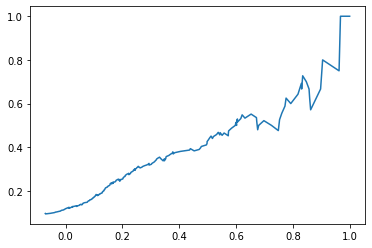

In [22]:
plt.plot(valid_threshold, valid_precision)

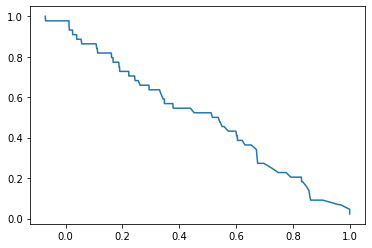

In [23]:
plt.plot(valid_threshold, valid_recall)

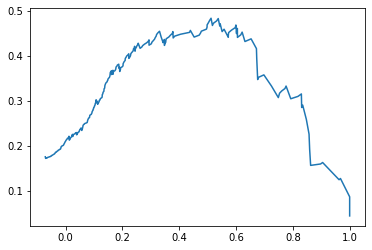

In [24]:
valid_f1 = [2*(i * j)/(i + j) for i , j in zip(valid_recall, valid_precision)]
plt.plot(valid_threshold, valid_f1)

In [25]:
#Validation Stats
index = np.argmax(valid_f1)
print("Optimal Threshold", valid_threshold[index])
print("Precision : ", valid_precision[index])
print("Recall : ", valid_recall[index])
print("F1 : ", valid_f1[index])
optimal_threshold = valid_threshold[index]

Optimal Threshold 0.5121529698371887
Precision :  0.45098039215686275
Recall :  0.5227272727272727
F1 :  0.48421052631578954


In [26]:
#Test Stats
test_ltable_title = []
test_rtable_title = []
test_label = []
for index, row in test_data.iterrows():
  test_ltable_title.append(row['ltable_title'])
  test_rtable_title.append(row['rtable_title'])
  test_label.append(float(row['label']))
best_model.eval()
test_preds = []
for i, j in zip(test_ltable_title, test_rtable_title):
  s1 = best_model.encode([i], convert_to_tensor=True)
  s2 = best_model.encode([j], convert_to_tensor=True)
  test_preds.append(util.pytorch_cos_sim(s1, s2).tolist()[0][0])
test_label_prediction = []
for val in test_preds:
  if(val >= optimal_threshold):
    test_label_prediction.append(1)
  else:
    test_label_prediction.append(0)
TP = 0
FP = 0
TN = 0
FN = 0
for i, j in zip(test_label, test_label_prediction):
  if(i == 1 and j == 1): TP+=1
  elif(i == 1 and j == 0): FP+=1
  elif(i == 0 and j == 0): TN+=1
  else: FN+=1
print("True Positives : ", TP)
print("False Positives : ", FP)
print("True Negatives : ", TN)
print("False Negatives : ", FN)
test_precision = TP/(TP+FP)
test_recall = TP/(TP + FN)
print("Precision : ", test_precision)
print("Recall ", test_recall)
print("F1 : ", (2*test_precision*test_recall/(test_precision + test_recall)))

True Positives :  22
False Positives :  37
True Negatives :  419
False Negatives :  22
Precision :  0.3728813559322034
Recall  0.5
F1 :  0.42718446601941745


## Category

In [27]:
model = SentenceTransformer('paraphrase-distilroberta-base-v1')

In [28]:
train_examples = []
count = 0
for index, row in train_data.iterrows():
  if(row['rtable_category'] is None or row['ltable_category'] is None): continue
  example = InputExample(texts=[row['ltable_category'], row['rtable_category']], label=float(row['label']))
  train_examples.append(example)
print(len(train_examples))
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=16)

3824


In [29]:
valid_ltable_category = []
valid_rtable_category = []
valid_label = []
for index, row in valid_data.iterrows():
  if(row['rtable_category'] is None or row['ltable_category'] is None): continue
  valid_ltable_category.append(row['ltable_category'])
  valid_rtable_category.append(row['rtable_category'])
  valid_label.append(float(row['label']))
print(len(valid_label))
validation_evaluator = evaluation.EmbeddingSimilarityEvaluator(valid_ltable_category, 
                                                               valid_rtable_category, 
                                                               valid_label)

476


In [30]:
scores = []
epochs = []
def print_after_epoch(score, epoch, steps):
  print(f"Score = {score} on epoch {epoch} and steps {steps}")
  scores.append(score)
  epochs.append(epoch)

In [31]:
train_loss = losses.CosineSimilarityLoss(model)
model.fit(train_objectives=[(train_dataloader, train_loss)], 
          epochs=10, 
          warmup_steps=100, 
          evaluator=validation_evaluator,
          save_best_model=True,
          output_path="./best_category_model_paraphrase-distilroberta-base-v1.pt",
          callback=print_after_epoch
          )


Score = 0.12646187878693996 on epoch 0 and steps -1



Score = 0.13650093325168539 on epoch 1 and steps -1



Score = 0.15706645188083052 on epoch 2 and steps -1



Score = 0.10585638536126654 on epoch 3 and steps -1



Score = 0.10262101511553247 on epoch 4 and steps -1



Score = 0.11514241682081752 on epoch 5 and steps -1



Score = 0.11993078856685198 on epoch 6 and steps -1



Score = 0.09651881099513843 on epoch 7 and steps -1



Score = 0.10060052942108745 on epoch 8 and steps -1



Score = 0.10265576765811586 on epoch 9 and steps -1



In [32]:
best_model = SentenceTransformer("./best_category_model_paraphrase-distilroberta-base-v1.pt")

In [33]:
best_model.eval()
valid_preds = []
for i, j in zip(valid_ltable_category, valid_rtable_category):
  s1 = best_model.encode([i], convert_to_tensor=True)
  s2 = best_model.encode([j], convert_to_tensor=True)
  valid_preds.append(util.pytorch_cos_sim(s1, s2).tolist()[0][0])

In [34]:
valid_precision, valid_recall, valid_threshold = precision_recall_curve(valid_label, valid_preds)
valid_precision = valid_precision[:-1]
valid_recall = valid_recall[:-1]

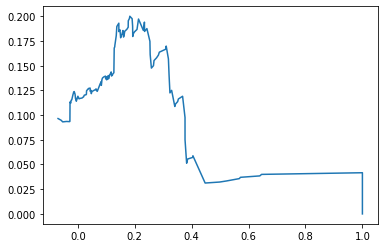

In [35]:
plt.plot(valid_threshold, valid_precision)

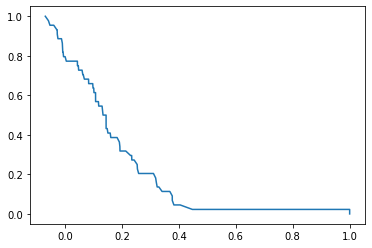

In [36]:
plt.plot(valid_threshold, valid_recall)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


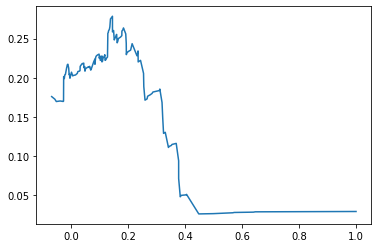

In [37]:
valid_f1 = [2*(i * j)/(i + j) for i , j in zip(valid_recall, valid_precision)]
plt.plot(valid_threshold, valid_f1)

In [38]:
#Validation Stats
valid_f1 = [x for x in valid_f1 if str(x) != 'nan']
index = np.argmax(valid_f1)
print("Optimal Threshold", valid_threshold[index])
print("Precision : ", valid_precision[index])
print("Recall : ", valid_recall[index])
print("F1 : ", valid_f1[index])
optimal_threshold = valid_threshold[index]

Optimal Threshold 0.1443149596452713
Precision :  0.19298245614035087
Recall :  0.5
F1 :  0.27848101265822783


In [39]:
#Test Stats
test_ltable_category = []
test_rtable_category = []
test_label = []
for index, row in test_data.iterrows():
  test_ltable_category.append(row['ltable_title'])
  test_rtable_category.append(row['rtable_title'])
  test_label.append(float(row['label']))
best_model.eval()
test_preds = []
for i, j in zip(test_ltable_category, test_rtable_category):
  s1 = best_model.encode([i], convert_to_tensor=True)
  s2 = best_model.encode([j], convert_to_tensor=True)
  test_preds.append(util.pytorch_cos_sim(s1, s2).tolist()[0][0])
test_label_prediction = []
for val in test_preds:
  if(val >= optimal_threshold):
    test_label_prediction.append(1)
  else:
    test_label_prediction.append(0)
TP = 0
FP = 0
TN = 0
FN = 0
for i, j in zip(test_label, test_label_prediction):
  if(i == 1 and j == 1): TP+=1
  elif(i == 1 and j == 0): FP+=1
  elif(i == 0 and j == 0): TN+=1
  else: FN+=1
print("True Positives : ", TP)
print("False Positives : ", FP)
print("True Negatives : ", TN)
print("False Negatives : ", FN)
test_precision = TP/(TP+FP)
test_recall = TP/(TP + FN)
print("Precision : ", test_precision)
print("Recall ", test_recall)
print("F1 : ", (2*test_precision*test_recall/(test_precision + test_recall)))

True Positives :  59
False Positives :  0
True Negatives :  0
False Negatives :  441
Precision :  1.0
Recall  0.118
F1 :  0.21109123434704832


## Combining signals

In [93]:
def jaccard_similarity(s1, s2):
    # print(s1)
    x = set(s1.lower().split())
    y = set(s2.lower().split())
    return len(x.intersection(y)) / max(len(x), len(y))

In [89]:
signals = labelled_data.copy()

In [97]:
best_title_model = SentenceTransformer("./best_title_model_paraphrase-distilroberta-base-v1.pt")
best_title_model.eval()
title_similarity = []
jackard_sim = []
leven_dist = []
for index, row in tqdm_notebook(labelled_data.iterrows()):
  s1 = best_title_model.encode(row['ltable_title'], convert_to_tensor=True)
  s2 = best_title_model.encode(row['rtable_title'], convert_to_tensor=True)
  title_similarity.append(util.pytorch_cos_sim(s1, s2).tolist()[0][0])
  # jackard_sim.append(jaccard_similarity(row['ltable_title'], row['rtable_title']))
  # leven_dist.append(levenshtein(row['ltable_title'], row['rtable_title']))
signals['title_similarity'] = np.array(title_similarity)
# signals['title_jaccard_similarity'] = np.array(jackard_sim)
# signals['title_leven_similarity'] = np.array(leven_dist)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [98]:
best_category_model = SentenceTransformer("./best_category_model_paraphrase-distilroberta-base-v1.pt")
best_category_model.eval()
category_similarity = []
jackard_sim = []
leven_dist = []
for index, row in labelled_data.iterrows():
  if( not(row['ltable_category'] is None) and not(row['rtable_category'] is None) ):
    s1 = best_category_model.encode(row['ltable_category'], convert_to_tensor=True)
    s2 = best_category_model.encode(row['rtable_category'], convert_to_tensor=True)
    category_similarity.append(util.pytorch_cos_sim(s1, s2).tolist()[0][0])
    # jackard_sim.append(jaccard_similarity(row['ltable_title'], row['rtable_title']))
    # leven_dist.append(levenshtein(row['ltable_title'], row['rtable_title']))
  else:
    category_similarity.append(-1)
    # leven_dist.append(-1)
    # jackard_sim.append(-1)
signals['category_similarity'] = np.array(category_similarity)
# signals['category_jaccard_similarity'] = np.array(jackard_sim)
# signals['category_leven_similarity'] = np.array(leven_dist)

In [99]:
brand_similarity = []
for index, row in labelled_data.iterrows():
  if( not(row['ltable_brand'] is None) and not(row['rtable_brand'] is None) ):
    brand_similarity.append(row['ltable_brand'] == row['rtable_brand'])
  else:
    brand_similarity.append(-1)
signals['brand_similarity'] = np.array(brand_similarity)

In [100]:
train_signals = signals.iloc[train_data.index]
valid_signals = signals.iloc[valid_data.index]
test_signals = signals.iloc[test_data.index]

#Random Forest (DO NOT RUN)

In [133]:
clf = RandomForestClassifier(class_weight="balanced", random_state=0)

In [135]:
features = train_signals[["brand_similarity", "category_similarity", "title_similarity"]]
labels = train_signals["label"]
#"category_jaccard_similarity", "category_leven_similarity","title_jaccard_similarity", "title_leven_similarity"

In [136]:
feats = features.to_numpy()
labels = labels.to_numpy()

In [137]:
clf.fit(feats, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [138]:
features_test = test_signals[["brand_similarity", "category_similarity", "title_similarity"]]
labels_test = test_signals["label"]
features_test = features_test.to_numpy()
labels_test = labels_test.to_numpy()

In [139]:
preds = clf.predict(features_test)

In [141]:
f1_score(labels_test, preds)

0.4814814814814815

In [142]:
features_valid = valid_signals[["brand_similarity", "category_similarity", "title_similarity"]]
labels_valid = valid_signals["label"]
features_valid = features_valid.to_numpy()
labels_valid = labels_valid.to_numpy()

In [143]:
preds_v = clf.predict(features_valid)

In [144]:
f1_score(labels_valid, preds_v)

0.4

#Regression

In [145]:
LEARNING_RATE = 0.01
BATCH_SIZE = 128
NUM_EPOCHS = 500
PREFITTING_NUM_EPOCHS = 10

In [146]:
feature_columns = [
    fc.numeric_column('title_similarity', default_value=-1),
    fc.numeric_column('category_similarity', default_value=-1),
    fc.categorical_column_with_vocabulary_list('brand_similarity', [0, 1, -1]),
    
]

In [147]:
train_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_signals[['title_similarity', 'category_similarity', 'brand_similarity']],
    y=train_signals[['label']]['label'],
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    num_threads=1)

# feature_analysis_input_fn is used to collect statistics about the input.
feature_analysis_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=train_signals[['title_similarity', 'category_similarity', "brand_similarity"]],
    y=train_signals[['label']]['label'],
    shuffle=False,
    batch_size=BATCH_SIZE,
    # Note that we only need one pass over the data.
    num_epochs=1,
    num_threads=1)

test_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=test_signals[['title_similarity', 'category_similarity', 'brand_similarity']],
    y=test_signals[['label']]['label'],
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    num_threads=1)

valid_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=valid_signals[['title_similarity', 'category_similarity', 'brand_similarity']],
    y=valid_signals[['label']]['label'],
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    num_threads=1)

# Serving input fn is used to create saved models.
serving_input_fn = (
    tf.estimator.export.build_parsing_serving_input_receiver_fn(
        feature_spec=fc.make_parse_example_spec(feature_columns)))

In [148]:
# Feature configs are used to specify how each feature is calibrated and used.
feature_configs = [
    tfl.configs.FeatureConfig(
        name='title_similarity',
    ),
    tfl.configs.FeatureConfig(
        name='category_similarity',
    ),
    tfl.configs.FeatureConfig(
        name='brand_similarity',
    ),
]

Test Precision: 0.4307692348957062
Test Recall: 0.47457626461982727
Test F1 Score: 0.45161290252028835


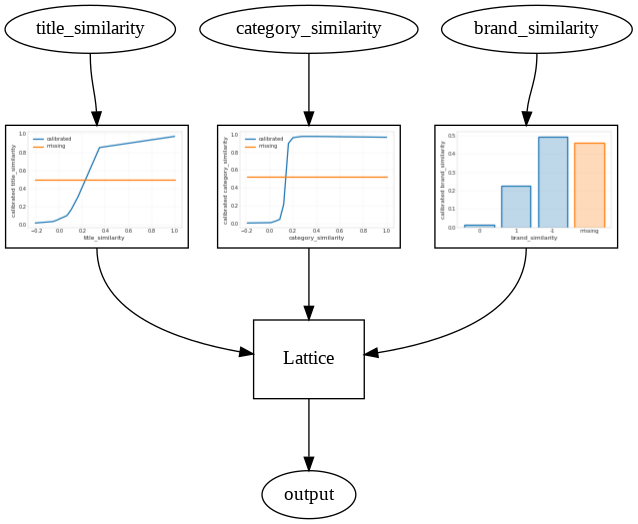

In [149]:
# Model config defines the model structure for the estimator.
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=feature_configs,
    regularizer_configs=[
        # Torsion regularizer applied to the lattice to make it more linear.
        tfl.configs.RegularizerConfig(name='torsion', l2=1e-4),
        # Globally defined calibration regularizer is applied to all features.
        tfl.configs.RegularizerConfig(name='calib_hessian', l2=1e-4),
    ])
# A CannedClassifier is constructed from the given model config.
estimator = tfl.estimators.CannedClassifier(
    feature_columns=feature_columns,
    model_config=model_config,
    feature_analysis_input_fn=feature_analysis_input_fn,
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
    config=tf.estimator.RunConfig(tf_random_seed=42)
    )
estimator.train(input_fn=train_input_fn)
results = estimator.evaluate(input_fn=test_input_fn)
print('Test Precision: {}'.format(results['precision']))
print('Test Recall: {}'.format(results['recall']))
precision = results['precision']
recall = results['recall']
print('Test F1 Score: {}'.format((2*precision*recall)/(precision + recall)))
saved_model_path = estimator.export_saved_model(estimator.model_dir,
                                                serving_input_fn)
model_graph = tfl.estimators.get_model_graph(saved_model_path)
tfl.visualization.draw_model_graph(model_graph)

In [150]:
test_predictions = []
for item in estimator.predict(input_fn=test_input_fn):
  if(item['logits'] > 0): test_predictions.append(1)
  else: test_predictions.append(0)

In [151]:
TP = 0
FP = 0
TN = 0
FN = 0
for i, j in zip(test_predictions, test_signals['label']):
  if(i == 1 and j == 1): TP+=1
  elif(i == 1 and j == 0): FP+=1
  elif(i == 0 and j == 0): TN+=1
  else: FN+=1
print("True Positives : ", TP)
print("False Positives : ", FP)
print("True Negatives : ", TN)
print("False Negatives : ", FN)
test_precision = TP/(TP+FP)
test_recall = TP/(TP + FN)
print("Precision : ", test_precision)
print("Recall ", test_recall)
print("F1 : ", (2*test_precision*test_recall/(test_precision + test_recall)))

True Positives :  28
False Positives :  37
True Negatives :  404
False Negatives :  31
Precision :  0.4307692307692308
Recall  0.4745762711864407
F1 :  0.4516129032258065


#Actual data prediction

In [70]:
ltable_no_train = ltable[~ltable.id.isin(train_data.ltable_id)]
rtable_no_train = rtable[~rtable.id.isin(train_data.rtable_id)]
# ltable_no_train = ltable_no_train.dropna()
# rtable_no_train = rtable_no_train.dropna()
# ltable_no_train.to_csv("./ltable_no_train.csv")
# rtable_no_train.to_csv("./rtable_no_train.csv")


In [71]:
embeddings = [best_title_model.encode(i, convert_to_tensor=True) for i in ltable_no_train.title]

In [ ]:
ltable_no_train["ltable_embeddings_title"] = copy.deepcopy(embeddings)

In [75]:
embeddings = [best_title_model.encode(i, convert_to_tensor=True) for i in rtable_no_train.title]

In [ ]:
rtable_no_train["rtable_embeddings_title"] = copy.deepcopy(embeddings)

In [ ]:
best_category_model = SentenceTransformer("./best_category_model_paraphrase-distilroberta-base-v1.pt")
best_category_model.eval()

In [79]:
embeddings = [best_category_model.encode(i, convert_to_tensor=True) for i in ltable_no_train.category]

In [ ]:
ltable_no_train["ltable_embeddings_category"] = copy.deepcopy(embeddings)

In [81]:
# if( not(row['ltable_category'] is None) and not(row['rtable_category'] is None) ):
# embeddings = [best_category_model.encode(i) for i in rtable_no_train.category if not i is None ]
category_similarity = []
for index, row in rtable_no_train.iterrows():
  if(not pd.isnull(row.category)):
    # print(row.category)
    s2 = best_category_model.encode(row.category, convert_to_tensor=True)
    category_similarity.append([s2])
    # category_similarity.append(util.pytorch_cos_sim(s1, s2).tolist()[0][0])
  else:
    category_similarity.append(-1)

In [82]:
rtable_no_train["rtable_embeddings_category"] = copy.deepcopy(category_similarity)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
# full_test_set = ltable_no_train.assign(key=1).merge(rtable_no_train.assign(key=1), on="key").drop("key", axis=1)

In [157]:
full_test_set = pd.read_pickle("/content/gdrive/MyDrive/4400-project/full_test_with_title_sim.pkl")

In [167]:
full_test_set.brand_x = full_test_set.brand_x.str.lower()
full_test_set.brand_x = full_test_set.brand_x.str.strip()

full_test_set.brand_y = full_test_set.brand_y.str.lower()
full_test_set.brand_y = full_test_set.brand_y.str.strip()

full_test_set_blocked = full_test_set[full_test_set.brand_x == full_test_set.brand_y]

In [175]:
import gc
gc.collect()

427

In [176]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [178]:
# best_title_model = SentenceTransformer("./best_title_model_paraphrase-distilroberta-base-v1.pt")
# best_title_model.eval()
actual_title_similarity = []  
actual_category_similarity = []
actual_brand_similarity = []
# title_x = full_test_set.title_x
# best_title_model.encode(full_test_set.title_x, convert_to_tensor=True, show_progress_bar=True)
for index in tqdm(range(full_test_set_blocked.shape[0])):
  row = full_test_set_blocked.iloc[index]
  # s1 = best_title_model.encode(row['title_x'], convert_to_tensor=True)
  # s2 = best_title_model.encode(row['title_y'], convert_to_tensor=True)
  actual_title_similarity.append(util.pytorch_cos_sim(row.ltable_embeddings_title, row.rtable_embeddings_title).tolist()[0][0])
  # rcat = row.rtable_embeddings_category[0].float()  else -1.0
  # print(util.pytorch_cos_sim(row.ltable_embeddings_category.float(), rcat).tolist()[0][0])
  # print('-----------------------------------------------')
  if row.rtable_embeddings_category != -1:
    actual_category_similarity.append(util.pytorch_cos_sim(row.ltable_embeddings_category.float(), row.rtable_embeddings_category[0].float()).tolist()[0][0])
  else:
    actual_category_similarity.append(-1)
  if (not pd.isna(row.brand_x) and not pd.isna(row.brand_y)):
    if (row.brand_x == row.brand_y):
      actual_brand_similarity.append(1)
    else:
      actual_brand_similarity.append(0)
  else:
    actual_brand_similarity.append(-1)

100%|██████████| 92591/92591 [01:01<00:00, 1514.81it/s]


In [179]:
# actual_title_similarity = []  
# actual_category_similarity = []
# actual_brand_similarity = []
full_test_set_blocked['title_similarity'] = actual_title_similarity
full_test_set_blocked['category_similarity'] = actual_category_similarity
full_test_set_blocked['brand_similarity'] = actual_brand_similarity


In [180]:
full_test_set_blocked

,id_x,title_x,category_x,brand_x,modelno_x,price_x,ltable_embeddings_title,ltable_embeddings_category,id_y,title_y,category_y,brand_y,modelno_y,price_y,rtable_embeddings_title,rtable_embeddings_category,title_similarity,category_similarity,brand_similarity
961,0,draper infrared remote transmitter,electronics - general,draper,121066,58.45,"[tensor(-0.0049, device='cuda:0'), tensor(0.0670, device='cuda:0'), tensor(-0.1768, de...","[tensor(0.3156, device='cuda:0'), tensor(-0.5259, device='cuda:0'), tensor(-0.0693, de...",1112,lcd lift a motorized projector lift,video projectors,draper,300031,NaN,"[tensor(-0.0424, device='cuda:0'), tensor(0.1183, device='cuda:0'), tensor(0.2932, dev...","[[tensor(-0.2052, device='cuda:0'), tensor(-0.4225, device='cuda:0'), tensor(0.0952, d...",0.040217,-0.037615,1
4540,0,draper infrared remote transmitter,electronics - general,draper,121066,58.45,"[tensor(-0.0049, device='cuda:0'), tensor(0.0670, device='cuda:0'), tensor(-0.1768, de...","[tensor(0.3156, device='cuda:0'), tensor(-0.5259, device='cuda:0'), tensor(-0.0693, de...",5165,draper revelation motorized ceiling-recessed projector mount model a - mounting kit ce...,projector mounts,draper,model a,NaN,"[tensor(-0.0916, device='cuda:0'), tensor(-0.2055, device='cuda:0'), tensor(0.0054, de...","[[tensor(-0.3715, device='cuda:0'), tensor(-0.5849, device='cuda:0'), tensor(0.0218, d...",0.111314,0.088138,1
4541,0,draper infrared remote transmitter,electronics - general,draper,121066,58.45,"[tensor(-0.0049, device='cuda:0'), tensor(0.0670, device='cuda:0'), tensor(-0.1768, de...","[tensor(0.3156, device='cuda:0'), tensor(-0.5259, device='cuda:0'), tensor(-0.0693, de...",5166,draper revelation motorized ceiling-recessed projector mount model b - mounting kit ce...,projector mounts,draper,model b,NaN,"[tensor(-0.0258, device='cuda:0'), tensor(-0.1518, device='cuda:0'), tensor(-0.0725, d...","[[tensor(-0.3715, device='cuda:0'), tensor(-0.5849, device='cuda:0'), tensor(0.0218, d...",0.088866,0.088138,1
6309,0,draper infrared remote transmitter,electronics - general,draper,121066,58.45,"[tensor(-0.0049, device='cuda:0'), tensor(0.0670, device='cuda:0'), tensor(-0.1768, de...","[tensor(0.3156, device='cuda:0'), tensor(-0.5259, device='cuda:0'), tensor(-0.0693, de...",7201,draper aero accuset angled ceiling plate - mounting component ceiling plate for projec...,tv mounts,draper,accuset angled ceiling plate,49.99,"[tensor(0.1903, device='cuda:0'), tensor(0.0081, device='cuda:0'), tensor(0.0141, devi...","[[tensor(-0.2528, device='cuda:0'), tensor(-0.4726, device='cuda:0'), tensor(0.1536, d...",0.098595,0.324607,1
9781,0,draper infrared remote transmitter,electronics - general,draper,121066,58.45,"[tensor(-0.0049, device='cuda:0'), tensor(0.0670, device='cuda:0'), tensor(-0.1768, de...","[tensor(0.3156, device='cuda:0'), tensor(-0.5259, device='cuda:0'), tensor(-0.0693, de...",11188,draper aero accuset ceiling plate - mounting component ceiling plate - ceiling mountable,tv mounts,draper,accuset ceiling plate,38.99,"[tensor(-0.0333, device='cuda:0'), tensor(-0.0784, device='cuda:0'), tensor(0.0806, de...","[[tensor(-0.2528, device='cuda:0'), tensor(-0.4726, device='cuda:0'), tensor(0.1536, d...",0.098900,0.324607,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25516832,2553,motorola mj270r 27 mile two way radio with 22 channels 121 privacy codes and noaa alert,walkie-talkie/frs,motorola,mj270r,47.11,"[tensor(0.0013, device='cuda:0'), tensor(0.1397, device='cuda:0'), tensor(-0.1909, dev...","[tensor(-0.1975, device='cuda:0'), tensor(-0.5958, device='cuda:0'), tensor(0.0756, de...",20985,motorola mr356 2-way camo frs gmrs radio camo,gmrs-frs two-way radios,motorola,mr356r,69.96,"[tensor(0.1485, device='cuda:0'), tensor(-0.7012, device='cuda:0'), tensor(-0.0431, de...","[[tensor(0.0651, device='cuda:0'), tensor(0.5821, device='cuda:0'), tensor(-0.2026, de...",0.028421,0.115016,1
25516833,2553,motorola mj270r 27 mile two way radi

In [181]:
full_input_fn = tf.compat.v1.estimator.inputs.pandas_input_fn(
    x=full_test_set_blocked[['title_similarity', 'category_similarity', 'brand_similarity']],
    # y=test_signals[['label']]['label'],
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_epochs=1,
    num_threads=1)

In [182]:
predictions_full = estimator.predict(input_fn=full_input_fn)

In [185]:
all_preds = {"ltable_id": [], "rtable_id": [], "logits": []}
for index, item in tqdm(enumerate(predictions_full)):
  if(item['logits'] > 0): 
    all_preds["ltable_id"].append(full_test_set_blocked.iloc[index].id_x)
    all_preds["rtable_id"].append(full_test_set_blocked.iloc[index].id_y)
    all_preds["logits"].append(item["logits"])
    # all_preds["label"].append(1)
  # else: all_preds.append(0)

92549it [00:03, 27863.04it/s]


In [186]:
#Show some results
df = pd.DataFrame(data=all_preds)

In [192]:
df.drop(columns=["logits"]).to_csv("submission.csv")

In [188]:
df.to_pickle("./all_preds.pkl")

In [190]:
all_preds = pd.read_pickle("./all_preds.pkl")
mset = {"ltitles":[], "rtitles":[], "logits":[]}
lids = set()
# print(ltable)
with tqdm(total=len(all_preds)) as tq:
    for index, item in all_preds.iterrows():
        lid, rid = item.ltable_id, item.rtable_id
        
        lt, rt = ltable.iloc[lid].title, rtable.iloc[rid].title
        # print(mset["logits"])
        # print(index)
        mset["ltitles"].append(lt)
        mset["rtitles"].append(rt)
        mset["logits"].append(item.logits)
        # lids.add(lid)
        tq.update(1)
df_a = pd.DataFrame(data=mset)
# df_a.to_csv("./unique_preds.csv")

100%|██████████| 2760/2760 [00:00<00:00, 2815.22it/s]


In [191]:
df_a

,ltitles,rtitles,logits
0,draper infrared remote transmitter,draper luma - projection screen - 109 in 277 cm - 16 10 - matt white - white,[1.5570656]
1,comprehensive two-piece 75 precision bnc jack for rg-59 set of 25,comprehensive ieee-1394 firewire - 6 pin jack to 4 pin plug adapter,[0.396181]
2,3m fr530cb ergonomic adjustable footrest,commercial performance heavy-duty single roll packaging tape 48mm x 50m tan mmm37502tn,[2.236455]
3,3m fr530cb ergonomic adjustable footrest,new-3m 3300f - permanent adhesive clear filing labels 2 3 x 3-7 16 white 1500 pack - m...,[0.1555072]
4,3m fr530cb ergonomic adjustable footrest,new-3m 3300g - permanent adhesive clear filing labels 2 3 x 3-7 16 assorted 750 pack -...,[0.30789104]
...,...,...,...
2755,draper cineflex cineperm fixed frame screen - 7 6 diagonal ntsc format,draper aero accuset ceiling plate - mounting component ceiling plate - ceiling mountable,[1.80966]
2756,draper cineflex cineperm fixed frame screen - 7 6 diagonal ntsc format,draper luma - projection screen - 109 in 277 cm - 16 10 - matt white - white,[0.30959445]
2757,cooler master 120mm silent blade master fan,coolermaster storm scout ultimate gaming cases power supplies - sgc-2000-kkn1-gp,[1.9330258]
2758,draper hidef grey shadowbox clarion fixed frame screen - 10 diagonal ntsc format,micro projector lift,[2.087657]


In [70]:
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive
